# 영화추천시스템

In [1]:
import pandas as pd
import numpy as np
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from numpy import dot
from numpy.linalg import norm

## Task 1. 데이터 준비하기
Task 1-1. 파일을 다운로드 받고 ua.base파일(학습데이터)과 ua.test파일(검증데이터)의 내용을 불러와서 Tensor 생성하기

In [2]:
train = pd.read_csv('./ua.base',
                    sep = "\t", names = ['user', 'movie', 'rating', 'timestamp'])
test = pd.read_csv('./ua.test',
                   sep = "\t", names = ['user', 'movie', 'rating', 'timestamp'])

In [3]:
train.head()

,user,movie,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


In [4]:
# 텐서 생성

# train set
items = torch.LongTensor(train['movie'])
users = torch.LongTensor(train['user'])
ratings = torch.FloatTensor(train['rating'])

# test set
items_test = torch.LongTensor(test['movie'])
users_test = torch.LongTensor(test['user'])
ratings_test = torch.FloatTensor(test['rating'])

Task 1-2. u.item 파일로부터 영와 id와 title 불러오기

In [5]:
movie_cols = ['movie_id', 'title']
movie = pd.read_csv('./u.item', sep = "|",encoding = 'latin-1',
                    names = movie_cols, usecols = range(2))

In [6]:
movie.head()

,movie_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


## Task 2. Latent Factor 모델을 이용하여 학습하기
Task 2-1. P, Q, bias_user, bias_item 등 파라미터 초기화하기

In [7]:
rank = 10

numItems = items.max() + 1
numUsers = users.max() + 1

#P,Q 값을 초기화
P = torch.randn(numItems, rank, requires_grad = True)
Q = torch.randn(numUsers, rank, requires_grad = True)

# bias를 계산하기 위한 값 초기화
bias_item = torch.randn(numItems, requires_grad = True)
bias_user = torch.randn(numUsers, requires_grad = True)

# loss 계산시 필요한 mean
mean = (ratings.sum() / len(ratings)).item()

# regulaztion
lambda1 = 0.0001
lambda2 = 0.0001

# loss의 bias를 위한 람다 값
b_lambda1 = 0.001
b_lambda2 = 0.001

Task 2-2. regularization과 bias를 적용하여 가설, 비용 설정하기

In [8]:
# 가설 함수(regulazation과 bias를 적용)
hypothesis = torch.sum(P[items] * Q[users], dim = 1) + mean + bias_item[items] + bias_user[users]

# 비용 함수
cost = F.mse_loss(hypothesis, ratings)\
+ lambda1 * torch.sum(P**2) + lambda2 * torch.sum(Q ** 2)\
+ b_lambda1 * torch.sum(bias_item ** 2) + b_lambda2 * torch.sum(bias_user ** 2) # Regularization & Bias

Task 2-3. torch.optim을 사용하여 학습하기

In [9]:
# optimzer 설정(Adam을 사용)
optimizer = torch.optim.Adam([P, Q, bias_item, bias_user], lr = 0.1)

# RMSE 값을 출력하기 위한 list
X = []
Y = []

Y_test = []

In [10]:
for epoch in range(1001):
    hypothesis = torch.sum(P[items] * Q[users], dim = 1) + mean + bias_item[items] + bias_user[users]
    
    cost = F.mse_loss(hypothesis, ratings)
    loss = (cost + lambda1 * torch.sum(P**2) + lambda2 * torch.sum(Q ** 2)\
    + b_lambda1 * torch.sum(bias_item ** 2) + b_lambda2 * torch.sum(bias_user ** 2)) ** 1/2
    # loss --> 각 원소의 제곱의 합.
    # overfitting 방지
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        hypo_test = torch.sum(P[items_test] * Q[users_test], dim = 1) + mean + bias_item[items_test] + bias_user[users_test]
        cost_test = (F.mse_loss(hypo_test, ratings_test))** 1/2
        
        X.append(epoch)
        Y.append(loss.item())
        
        Y_test.append(cost_test.item())
    
    if epoch % 100 == 0:
        print(f"epoch: {epoch}, cost: {loss.item():.6f}")

C:\ProgramData\Anaconda3\lib\site-packages\torch\autograd\__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


epoch: 0, cost: 9.121841
epoch: 100, cost: 0.419205
epoch: 200, cost: 0.410964
epoch: 300, cost: 0.409801
epoch: 400, cost: 0.409539
epoch: 500, cost: 0.409346
epoch: 600, cost: 0.409189
epoch: 700, cost: 0.409103
epoch: 800, cost: 0.409057
epoch: 900, cost: 0.409040
epoch: 1000, cost: 0.409035


Task 2-4. 학습데이터와 검증데이터에 대해서 각 RMSE값을 구하여 출력하기(Trainging RMSE, test RMSE)

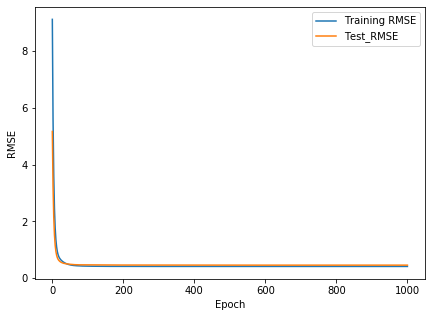

In [11]:
plt.figure(figsize = (7,5))
plt.ylabel("RMSE")
plt.xlabel('Epoch')
plt.plot(X,Y, label = "Training RMSE")
plt.plot(X,Y_test, label = "Test_RMSE")
plt.legend()
plt.show()

## Task 3. 13번 User에게 추천하기 (knn search)
Task 3-1.  13번 User의 예상 별점이 가장 높은 영화 top 20개를 찾아서 id 및 영화이름 출력하기

In [12]:
# User13번의 모든 1682개의 movie의 예상 별점을 구함.

expect_rating = []
for i in range(1, len(movie['movie_id']) +1):
    expect_rating.append(torch.sum(P[i] * Q[13]).item())

In [13]:
# User 13번의 모든 movie의 예상 별점을 DataFrame 타입으로 변환

expect_result = pd.DataFrame({'movie_id': np.arange(1,len(P)),
                              'rating': expect_rating})
expect_result.head()

,movie_id,rating
0,1,-0.595016
1,2,-0.565272
2,3,0.907981
3,4,0.804552
4,5,-1.435921


In [14]:
# 영화의 id와 title을 담고 있는 movie Dataframe 과 user13의 예상 별점을 담고 있는 expect_result Dataframe을 left merge함

user13 = expect_result.merge(movie, on = 'movie_id', how = 'left')\
.sort_values(by = 'rating', ascending = False)[:20][['movie_id', 'title', 'rating']]

user13

,movie_id,title,rating
49,50,Star Wars (1977),3.124968
180,181,Return of the Jedi (1983),2.994747
171,172,"Empire Strikes Back, The (1980)",2.608649
134,135,2001: A Space Odyssey (1968),2.566540
510,511,Lawrence of Arabia (1962),2.193685
662,663,Being There (1979),2.115699
1141,1142,When We Were Kings (1996),2.114225
173,174,Raiders of the Lost Ark (1981),2.081641
133,134,Citizen Kane (1941),2.072913
186,187,"Godfather: Part II, The (1974)",2.061202


Task 3-2. Latent Matrix P와 Q를 이용하여 13번 User와 cosine similarity가 가장 유사한 영화 top20개를 찾아서 id 및 영화 이름 출력하기

In [15]:
def cosine_sim(a, b):
    #grad 속성을 가진 tensor는 연산이 불가능함.
    x = P[a].detach() # movie(item)의 tensor
    y = Q[b].detach() # user의 tensor
    return dot(x,y)/(norm(x)*norm(y))

In [16]:
movie_id = []
cosine_similarity = []
for i in range(len(P)):
    movie_id.append(i)
    
    cos = cosine_sim(i,13)
    cosine_similarity.append(round(cos,4))

In [17]:
user13_sim = pd.DataFrame({'movie_id': movie_id[1:],
                           'cosine_similarity' : cosine_similarity[1:]})
user13_sim = user13_sim.merge(movie, on = 'movie_id', how = 'left') #P[0]의 값은 의미가 없는 값이므로 생략함.

In [18]:
# user13과 cosine 유사도가 높은 상위 20개의 영화 출력
user13_sim = user13_sim[['movie_id','title', 'cosine_similarity']].sort_values(by ='cosine_similarity', ascending = False)[:20]
user13_sim

,movie_id,title,cosine_similarity
813,814,"Great Day in Harlem, A (1994)",1.0000
867,868,Hearts and Minds (1996),0.9340
866,867,"Whole Wide World, The (1996)",0.9014
847,848,"Murder, My Sweet (1944)",0.8669
908,909,Dangerous Beauty (1998),0.8031
591,592,True Crime (1995),0.7464
810,811,Thirty-Two Short Films About Glenn Gould (1993),0.7135
1540,1541,"Beans of Egypt, Maine, The (1994)",0.7045
1655,1656,Little City (1998),0.6860
899,900,Kundun (1997),0.6470


- Task5-3-2에 필요한 결과값 저장

In [19]:
rate = user13['movie_id'].tolist()
sim = user13_sim['movie_id'].tolist()

## Task 4. 영화 클러스터링하기(K-Means Clustering)
Task 4-1. 다음을 만족하는 k-means clustering 알고리즘 구현하기 </p>
-각 영화가 속한 cluster를 정할 때, cosine similarity를 기준으로 정하기 </p>

In [20]:
def cosine_sim_P(a, b):
    #grad 속성을 가진 tensor는 연산이 불가능함.
    return dot(a,b)/(norm(a)*norm(b))

In [21]:
def kmeans(k, points):
    prev_assignments = []
    
    #1. 랜덤으로 중심점(centroid) 선택
    centroids = points[np.random.choice(points.shape[0], replace = False, size = k)]
    
    for epoch in range(10):
        #2. 각 점마다 가장 가까운 centroid의 cluster에 점 할당
        assignments = [assign(p, centroids, k) for p in points]
        
        #3. cluster의 평균을 구해서 centroid 업데이트
        centroids = compute_centroids(assignments, points, k)
        
        #4. cluster가 변했는지 확인하고, 변해으면 계속, 변하기 않았으면 멈춤
        if prev_assignments == assignments:
            break
        prev_assignments = assignments
        
    return assignments, centroids

In [22]:
def assign(point, centroids, k):
    return min(range(k), key = lambda i: cosine_sim_P(centroids[i], point))

In [23]:
def compute_centroids(assignments, points, k):
    vec_sum = [np.zeros(len(points[0])) for _ in range(k)]
    counts = [0] * k
    
    for i, p in zip(assignments, points):
        vec_sum[i] += p
        counts[i] += 1
        
    return [vec_sum[i] / counts[i] if counts[i] > 0 else random.choice(points) for i in range(k)]

In [24]:
# P (영화에 대한 행렬)를 kmean의 input이 되도록 array 로 변경
points = np.array(P.detach())

In [25]:
#K_means 실행해보기
#kmeans_result = kmeans(4, points)
# --> 첫번째 값 = 각 영화들의 군집, 중심점(centroid)

Task 4-2. k=1, k=2 ... k=40 까지 바꿔가면서 cost값을 계산하고 이를 matplotlib을 활용하여 그래프로 그리기

In [26]:
# 텐서 형태의 P를 array 형태로 변환하여 계산
P_for_cost = np.array(P.detach())

In [27]:
def dist(x,y):   
    return np.sum((x-y)**2)

In [28]:
#각 cluster에서 centroid와 좌표간의 cost구하는 functon

def cal_cost(k):
    cost = 0
    for i in range(0, 1683):
        for j in range(0,k):
            if movie_clustered['cluster'][i] == j:
                a = P_for_cost[i]
                b = kmeans_result[1][j]
                cost += dist(a, b)
    print('k: ', k, 'cost:', cost)
    return cost

In [29]:
# 각 k의 centroid에 따른 cost 계산하여 list에 저장.
cost_list = []

for i in range(1,41):
    kmeans_result = kmeans(i,points)
        
    movie_clustered = pd.DataFrame({'movie_id': np.arange(0,1683),
                                    'cluster': kmeans_result[0]})
    cost = cal_cost(i)
    cost_list.append(cost)

k:  1 cost: 905.866977412953
k:  2 cost: 771.1917253243339
k:  3 cost: 724.9277502523191
k:  4 cost: 701.230018028861
k:  5 cost: 673.2975225632881
k:  6 cost: 663.703748585986
k:  7 cost: 643.6661510793931
k:  8 cost: 650.2293753501459
k:  9 cost: 630.4646689122699
k:  10 cost: 624.8571912649916
k:  11 cost: 622.204504250356
k:  12 cost: 605.6038170006639
k:  13 cost: 602.6207425549138
k:  14 cost: 612.8701882815899
k:  15 cost: 590.6578851472879
k:  16 cost: 588.6539628058769
k:  17 cost: 585.6348978072054
k:  18 cost: 579.4427993011914
k:  19 cost: 573.2905284781633
k:  20 cost: 574.3915591757053
k:  21 cost: 573.3307321187735
k:  22 cost: 569.978781753996
k:  23 cost: 578.3331426913614
k:  24 cost: 555.9177897851882
k:  25 cost: 558.5649756160351
k:  26 cost: 556.1044885121717
k:  27 cost: 542.5789909830934
k:  28 cost: 540.3727027758853
k:  29 cost: 542.7176348778995
k:  30 cost: 544.9347457729639
k:  31 cost: 540.8944082744999
k:  32 cost: 532.4144823199209
k:  33 cost: 526.38144

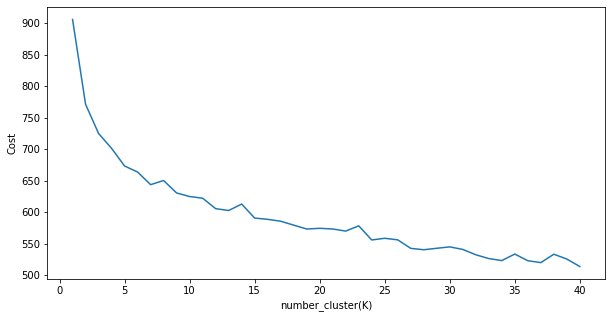

In [30]:
plt.figure(figsize = (10,5))
X = np.arange(1, 41)
Y = cost_list
plt.plot(X,Y)
plt.xlabel('number_cluster(K)')
plt.ylabel('Cost')
plt.show()

Task 4-3. 가장 적절해보이는 k 선택하기
- K값이 커짐에 따른 감소된 Cost를 보고 판단

In [31]:
cl = cost_list[1:]
rd = [] #reduced cost
for i, c in enumerate(cl):
    reduce = cost_list[i] - cl[i]
    rd.append(reduce)

In [32]:
pd.DataFrame({'K_cluster': range(2,41),
             'Reduced_Cost': rd})[:10]

,K_cluster,Reduced_Cost
0,2,134.675252
1,3,46.263975
2,4,23.697732
3,5,27.932495
4,6,9.593774
5,7,20.037598
6,8,-6.563224
7,9,19.764706
8,10,5.607478
9,11,2.652687


### 결론) k = 5일때  cost값이 많이 감소하며, 전체 데이터의 개수를 보아 적당한 값으로 판단됨

In [33]:
kmeans_result = kmeans(5, points)

## Task5. 차원 축소 및 시각화(PCA)
Task 5-1. P행렬과 Q행렬을 합쳐 Z행렬 만들기

In [34]:
X = torch.cat([P.detach(),Q.detach()])
Z = X-X.mean(axis = 0)

Task 5-2. Z행렬에서 PCA수행하여 2차원 데이터로 줄인 Zp 만들기 </p>
*외부 library를 사용해도 무방함.

In [35]:
def findPC(Z):
    w = torch.randn(Z.shape[1])
    w = w/(torch.dot(w,w))**0.5
    
    lr = 0.1
    
    for epoch in range(1001):
        w.requires_grad_(True)
        variance = torch.mean(torch.sum(Z * w, dim = 1) ** 2)
        
        variance.backward()
        
        with torch.no_grad():
            w = w + lr * w.grad
            w = w/(torch.dot(w,w)) ** 0.5
            
    return w, variance.item()

In [36]:
def PCA(Z, n):
    W, V = [], []
    
    for _ in range(n):
        w, v = findPC(Z)
        W.append(w.tolist())
        V.append(v)
        Z = Z -(Z @ w.unsqueeze(1)) * w
        
    return W, V

In [37]:
def transform(Z, W):
    return Z @ torch.Tensor(W).T

In [38]:
W, V = PCA(Z, 10)
Zp = transform(Z,W)

Task 5-3. matplotlib를 사용하여 Zp의 scatter plot 그리기 <p/>
Task 5-3-1. P행렬과 Q행렬의 점들을 서로 다른 색으로 그리기

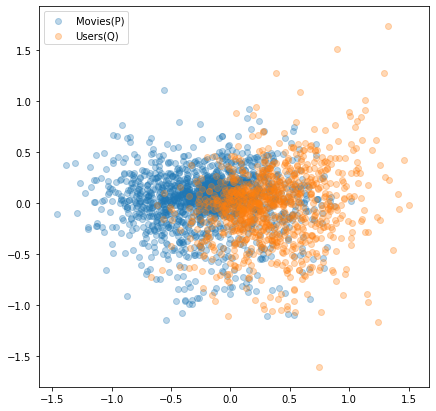

In [39]:
plt.figure(figsize = (7,7))
plt.scatter(Zp[:1684,0], Zp[:1684,1], alpha = 0.3, label = 'Movies(P)')
plt.scatter(Zp[1683:,0], Zp[1683:,1], alpha = 0.3, label = 'Users(Q)') # Q값들

plt.legend()
plt.show()

Task 5-3-2. Task3의 결과 점들을 다른 색으로 그려 강조하기

In [40]:
# task3의 결과값의 movie_id를 저장한 list --> rate, sim
result_x_rate = []
result_y_rate = []
result_x_sim = []
result_y_sim = []

for i in rate:
    result_x_rate.append(np.array(Zp[i, 0]))
    result_y_rate.append(np.array(Zp[i, 1]))
    
for j in sim:
    result_x_sim.append(np.array(Zp[j, 0]))
    result_y_sim.append(np.array(Zp[j, 1]))

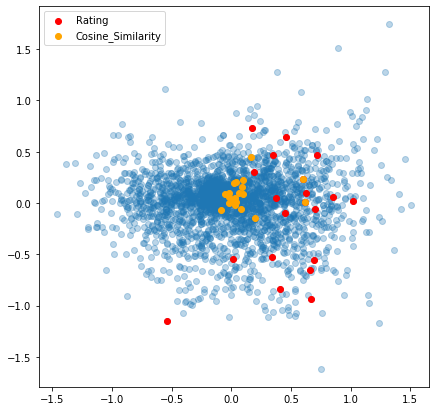

In [41]:
plt.figure(figsize = (7,7))
plt.scatter(Zp[:,0], Zp[:,1], alpha = 0.3)

plt.scatter(result_x_rate, result_y_rate,  c = 'red', alpha = 1, label = 'Rating')
plt.scatter(result_x_sim, result_y_sim, c = 'orange', alpha = 1, label = 'Cosine_Similarity')

plt.legend()
plt.show()

Task 5-3-3. Task4에서 구한 cluster들을 각기 다른 색으로 그리기

In [42]:
Zp_points = np.array(Zp)
kmeans_Zp_result = kmeans(5,Zp_points)

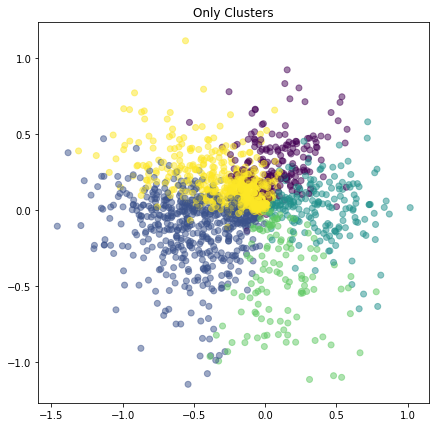

In [43]:
plt.figure(figsize = (7,7))
plt.title('Only Clusters')
plt.scatter(Zp_points[1:1683,0], Zp_points[1:1683,1], c = kmeans_Zp_result[0][1:1683], alpha = 0.5) # cluster된 영화들
plt.show()

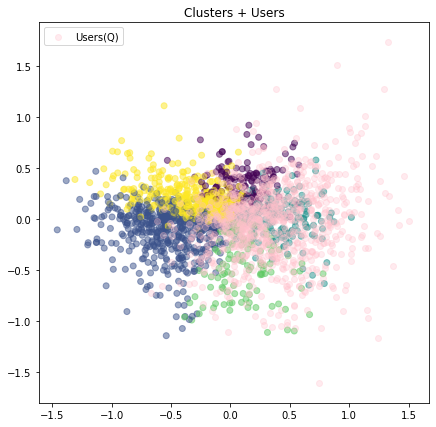

In [44]:
plt.figure(figsize = (7,7))
plt.title('Clusters + Users')

plt.scatter(Zp_points[1:1683,0], Zp_points[1:1683,1], c = kmeans_Zp_result[0][1:1683], alpha = 0.5) # cluster된 영화들
plt.scatter(Zp_points[1684:,0], Zp_points[1684:,1], c = 'pink', alpha = 0.3, label= 'Users(Q)') # Q값들의 집합

plt.legend()
plt.show()